# Transfer ResNet18 model

## 1. 공식 문서의 resnet18 설명을 참고하여 ResNet18 모델을 로드 합니다.


* weights 는 ResNet18_Weights.IMAGENET1K_V2 사용합니다.
* model 을 로드한 후 구조를 콘솔에 출력해 봅니다.

https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#resnet18

In [1]:
from torchvision.models import resnet18, ResNet18_Weights

In [2]:
weights = ResNet18_Weights.IMAGENET1K_V1

In [3]:
model = resnet18(weights=weights)

## 2. 로드한 모델의 파라미터가 학습 중 update 되지 않도록 조치합니다.

In [4]:
for p in model.parameters():
  p.requires_grad = False

## 3. Pytorch 의 ResNet18 모델은 IMAGENET1K 를 이용하여 사전 훈련됐습니다(출력이 1000개).

* 모델의 마지막 레이이인 fully connected 를 새로운 Linear 레이어로 변경합니다. 이때, Linear 레이어의 출력은 FashionMNIST 데이터셋의 label 개수를 고려하여 10 입니다.


* 마지막으로 torch.rand 를 이용하여 (32, 3, 224, 224) 크기의 데이터를 생성하여 모델에 입력으로 제공하고 출력의 shape 이 (32, 10) 임을 확인합니다.

In [7]:
import torch.nn as nn
import torch

model.fc = nn.Linear(512,10)

In [6]:
model.fc

Linear(in_features=512, out_features=10, bias=True)

In [9]:
input = torch.rand(32, 3, 224, 224)
input.shape
x = model(input)
x.shape

torch.Size([32, 10])

## 3.1 모델의 규모가 크기 때문에 GPU 를 이용할 수 있는 경우 이를 사용하여 모델을 학습합니다. 먼저, 로드한 모델을 GPU 로 이동합니다.

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 4. Pytorch 의 ResNet18 모델은 IMAGENET1K 를 이용하여 사전 훈련됐습니다. 따라서, (224, 224) 크기의 컬러 이미지를 입력으로 받습니다.

* FashionMNIST 는 (1, 28, 28) 크기로 모델을 입력으로 사용할 수 없기 때문에 변환(transform) 이 필요합니다. 제공되는 transform 을 이용하여 FasionMNIST 데이터셋을 resnet18 의 입력으로 사용할 수 있도록 코드를 작성하세요.

https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.ResNet18_Weights


In [38]:
### 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # 데이터 전처리에 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader


In [39]:
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import torchvision.transforms.v2 as v2

In [44]:
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

crop_size = weights.transforms.keywords['crop_size']
resize_size = 224

transform = v2.Compose([
    v2.Grayscale(num_output_channels=3),
    v2.Resize((resize_size, resize_size), interpolation=InterpolationMode.BILINEAR),
    v2.CenterCrop((crop_size, crop_size)),
    # transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])


In [55]:
import torchvision.transforms as transforms  # 'transforms' 별칭 정의
from torchvision import datasets
dataset_train = torchvision.datasets.FashionMNIST(".", download=True, 
                                                  transform=transform)

In [56]:
from torch.utils.data import DataLoader

In [57]:
loader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

In [30]:
# train_loader = torch.utils.data.DataLoader(train_dataset,
#                                            batch_size=100)
# test_loader = torch.utils.data.DataLoader(test_dataset,
#                                           batch_size=100)

In [58]:
for X, y in loader_train:
  print(X.shape, y.shape, X.device, y.device)
  break

torch.Size([32, 3, 224, 224]) torch.Size([32]) cpu cpu


## 5. 손실함수 (torch.nn.CrossEntropyLoss) 와 옵티마이저(torch.optim.Adam) 를 생성합니다.

In [59]:
loss_fn = torch.nn.CrossEntropyLoss()

In [60]:
optimizer = torch.optim.Adam(model.parameters())

## 6. train loop 를 구현하여 모델을 학습시켜 봅니다. 또한, loss_history 리스트에 loss 값을 저장하고 loss 값을 콘솔에 출력합니다.

In [86]:
lost_hist = []

for epoch in range(10):
  for X, y in loader_train:
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_hist.append(loss.item())
print(f'epochsL {epoch}, loss: {loss}')

KeyboardInterrupt: 

## 7. epoch 에 따른 loss 의 변화를 plot 으로 나타냅니다.

In [85]:
import matplotlib.pyplot as plt
import numpy as np
loss = loss.cpu().numpy()
plt.plot(loss)
plt.show()

AttributeError: 'builtin_function_or_method' object has no attribute 'cpu'

# 8. 학습된 모델과 loader_test 를 이용하여 모델의 성능을 테스트해 봅니다.

In [ ]:
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
images = images * std + mean

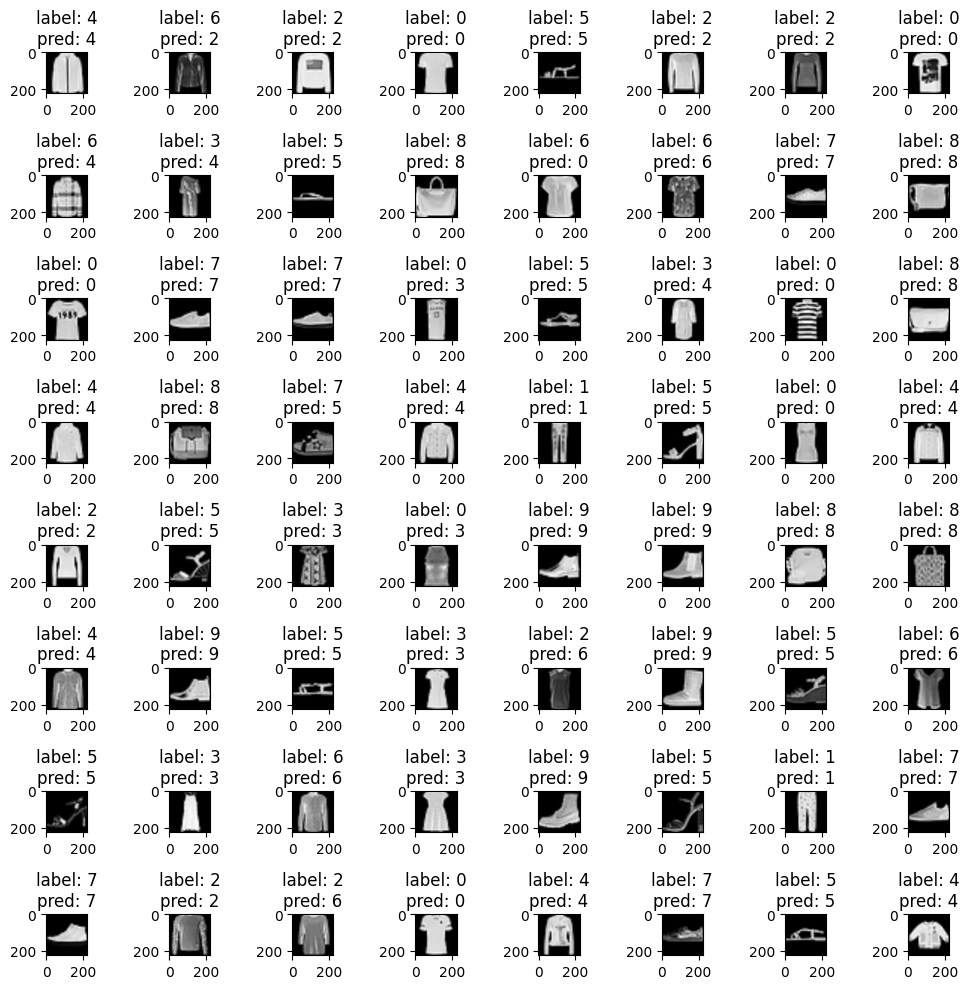

## 9. 교재에서 제공하는 github 자료의 chap06/data/catanddog 데이터를 자신의 개발 환경으로 복사합니다. p296 의 transforms 를 준비합니다. p297 를 참고하여 ImageFolder 클래스를 이용하여 dataset_train, dataset_test 를 준비합니다.

In [89]:
import torch
from torchvision.datasets import ImageFolder

In [92]:
train_path = 'catanddog/train'
dataset_train = ImageFolder(train_path)

In [93]:
test_path = 'catanddog/train'
dataset_train = ImageFolder(test_path)

In [95]:
import torchvision.transforms.v2 as v2
transforms = v2.Compose([
  v2.Resize((224, 224)),
  v2.ToImage(),
  v2.ToDtype(torch.float32, scale=True)])

In [97]:
dataset_train = ImageFolder(test_path, transform=transforms)

## 10. 파이토치에서 제공하는 ResNet18 모델을 이용하여 개와 고양이를 구분하는 모델을 transfer learning 방식으로 빌드 후, 훈련 loss, 테스트 데이터를 이용한 모델의 성능을 확인해 봅니다.

In [108]:
import torch.nn as nn
import torch
from torchvision.models import resnet18, ResNet18_Weights

# 사전 학습된 ResNet18 모델을 불러옴 (ImageNet에서 학습된 가중치 사용)
weights = ResNet18_Weights.IMAGENET1K_V1
model = resnet18(weights=weights)

# 모델의 모든 가중치의 기울기 계산을 중단 (특징 추출기로 사용하기 위함)
for p in model.parameters(): 
      p.requires_grad = False
      
# ResNet18의 최종 Fully Connected Layer를 커스터마이즈
# 기본적으로 ResNet18의 출력 채널이 512이므로 이를 받아 2개의 클래스를 출력하도록 수정
model.fc = nn.Linear(512, 2)

# GPU를 사용할 수 있으면 GPU로 설정, 그렇지 않으면 CPU로 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 데이터로더를 설정 (train 데이터를 배치 사이즈 100으로 섞어서 로드)
loader_train = DataLoader(dataset_train, batch_size=100, shuffle=True)

# 데이터 로드 확인: 입력 데이터(X)와 레이블(y)의 형태 및 디바이스 정보 출력
for X, y in loader_train:
  print(X.shape, y.shape, X.device, y.device)
  break

# 손실 함수로 CrossEntropyLoss 사용 (다중 클래스 분류용)
loss_fn = torch.nn.CrossEntropyLoss()

# 옵티마이저로 Adam 설정
optimizer = torch.optim.Adam(model.parameters())

# 학습 중 손실 값을 기록할 리스트 초기화
loss_hist = []

# 학습 루프 시작 (10 에포크 동안 진행)
for epoch in range(10):
  for X, y in loader_train:
    # 데이터를 GPU 또는 CPU로 이동
    X, y = X.to(device), y.to(device)
    
    # 모델 예측 수행
    y_pred = model(X)
    
    # 예측 결과와 정답 레이블 간 손실 계산
    loss = loss_fn(y_pred, y)
    
    # 옵티마이저 초기화 (이전의 기울기 제거)
    optimizer.zero_grad()
    
    # 손실에 대한 역전파 수행
    loss.backward()
    
    # 가중치 갱신
    optimizer.step()
    
    # 현재 손실 값을 기록
    loss_hist.append(loss.item())
  
  # 에포크 별 손실 값 출력
  print(f'epochs: {epoch}, loss: {loss}')

# --- 전체적인 흐름 ---
# 1. 사전 학습된 ResNet18 모델을 불러와 최종 FC Layer를 수정하여 2개의 클래스를 출력하도록 변경.
# 2. 모델의 사전 학습된 가중치는 고정(freeze)하고 특징 추출기로 사용.
# 3. 데이터로더를 통해 배치 단위로 데이터를 불러옴.
# 4. CrossEntropyLoss를 사용하여 다중 클래스 분류 손실 계산.
# 5. Adam 옵티마이저로 모델 파라미터를 학습.
# 6. 각 에포크마다 데이터 배치를 반복적으로 처리하며 손실 계산, 역전파, 가중치 갱신 수행.
# 7. 학습 진행 상황을 손실 값으로 출력하고 기록.


torch.Size([100, 3, 224, 224]) torch.Size([100]) cpu cpu
epochsL 0, loss: 0.5070062875747681
epochsL 1, loss: 0.3025335371494293
epochsL 2, loss: 0.2967086136341095
epochsL 3, loss: 0.20412597060203552
epochsL 4, loss: 0.15528643131256104
epochsL 5, loss: 0.07137489318847656
epochsL 6, loss: 0.09401357918977737
epochsL 7, loss: 0.13750889897346497
epochsL 8, loss: 0.11886793375015259
epochsL 9, loss: 0.09966840595006943


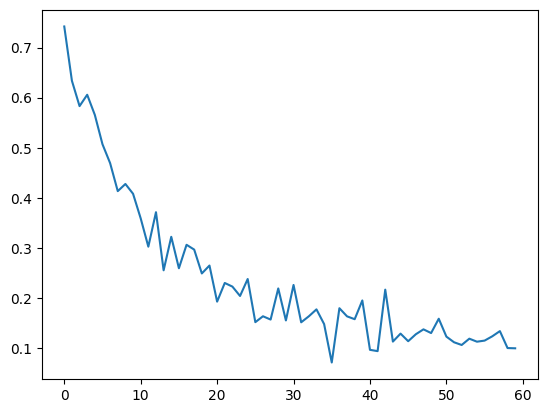

In [109]:

plt.plot(range(len(loss_hist)), loss_hist)